In [1]:
import sys

sys.path.append("..")
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import logging
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    auc,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)

logging.basicConfig(level=logging.INFO)

In [2]:
df = pd.read_csv("californiabin.csv", header=None)
print(df.describe())

                 0            1            2            3             4  \
count  2000.000000  2000.000000  2000.000000  2000.000000   2000.000000   
mean      3.904364    28.509500     5.417501     1.090020   1421.657500   
std       1.912417    12.715099     2.121688     0.348978   1225.902672   
min       0.536000     2.000000     0.888889     0.500000      9.000000   
25%       2.586875    18.000000     4.439494     1.004505    784.000000   
50%       3.574450    28.000000     5.283862     1.048582   1173.000000   
75%       4.753675    38.000000     6.064881     1.098424   1714.250000   
max      15.000100    52.000000    56.269231    10.153846  28566.000000   

                 5            6            7            8  
count  2000.000000  2000.000000  2000.000000  2000.000000  
mean      2.909150    35.697790  -119.646690     0.500000  
std       0.742232     2.150273     1.999555     0.500125  
min       1.066176    32.550000  -124.180000     0.000000  
25%       2.420881    33

In [3]:
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42069, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (1600, 8), Test shape: (400, 8)


In [4]:
# C: 2^-5 to 2^15
C_range = 2 ** np.arange(-5.0, 15.0, 1)
# gamma: 2^-15 to 2^3
gamma_range = 2 ** np.arange(-15.0, 3.0, 2)

param_grid_svm = {"C": C_range, "gamma": gamma_range, "kernel": ["rbf"]}

svm = SVC(probability=True, random_state=42069)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42069)

grid_svm = GridSearchCV(
    svm, param_grid_svm, cv=cv, scoring="accuracy", n_jobs=-1, verbose=1
)

grid_svm

,estimator,SVC(probabili...m_state=42069)
,param_grid,"{'C': array([3.1250..., 1.6384e+04]), 'gamma': array([3.0517...00000000e+00]), 'kernel': ['rbf']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1.0


In [5]:
grid_svm.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


,estimator,SVC(probabili...m_state=42069)
,param_grid,"{'C': array([3.1250..., 1.6384e+04]), 'gamma': array([3.0517...00000000e+00]), 'kernel': ['rbf']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,np.float64(1024.0)


In [6]:
print(f"Best SVM Parameters: {grid_svm.best_params_}")
best_svm = SVC(
    **grid_svm.best_params_,
    probability=True,
    random_state=42069,
)
best_svm.fit(X_train_scaled, y_train)

Best SVM Parameters: {'C': np.float64(1024.0), 'gamma': np.float64(0.0078125), 'kernel': 'rbf'}


,C,np.float64(1024.0)
,kernel,'rbf'
,degree,3
,gamma,np.float64(0.0078125)
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [7]:
# n_estimators: 10, 20, ..., 200
n_estimators_range = np.arange(10, 201, 10)
# max_depth: 4, 6, 8, 10, None
max_depth_range = [4, 6, 8, 10, None]

param_grid_rf = {"n_estimators": n_estimators_range, "max_depth": max_depth_range}

rf = RandomForestClassifier(random_state=42069)

grid_rf = GridSearchCV(
    rf, param_grid_rf, cv=cv, scoring="accuracy", n_jobs=-1, verbose=1
)

grid_rf

,estimator,RandomForestC...m_state=42069)
,param_grid,"{'max_depth': [4, 6, ...], 'n_estimators': array([ 10, ...80, 190, 200])}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [8]:
grid_rf.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,estimator,RandomForestC...m_state=42069)
,param_grid,"{'max_depth': [4, 6, ...], 'n_estimators': array([ 10, ...80, 190, 200])}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,np.int64(60)


In [9]:
print(f"Best RF Parameters: {grid_rf.best_params_}")
best_rf = RandomForestClassifier(**grid_rf.best_params_, random_state=42069)
best_rf.fit(X_train, y_train)

Best RF Parameters: {'max_depth': 10, 'n_estimators': np.int64(60)}


,n_estimators,np.int64(60)
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"{model_name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"F1-Score: {f1:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    print(f"AUROC: {roc_auc:.4f}")
    print(f"AUPRC: {pr_auc:.4f}")

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    ax[0].plot([0, 1], [0, 1], "k--")
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    ax[0].set_title(f"ROC - {model_name}")
    ax[0].legend(loc="lower right")

    ax[1].plot(recall, precision, label=f"PR curve (area = {pr_auc:.2f})")
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")
    ax[1].set_title(f"Precision-Recall - {model_name}")
    ax[1].legend(loc="lower left")

    plt.tight_layout()
    plt.show()

SVM Performance:
Accuracy: 0.8500
Recall: 0.8750
Precision: 0.8333
F1-Score: 0.8537
AUROC: 0.9210
AUPRC: 0.9131


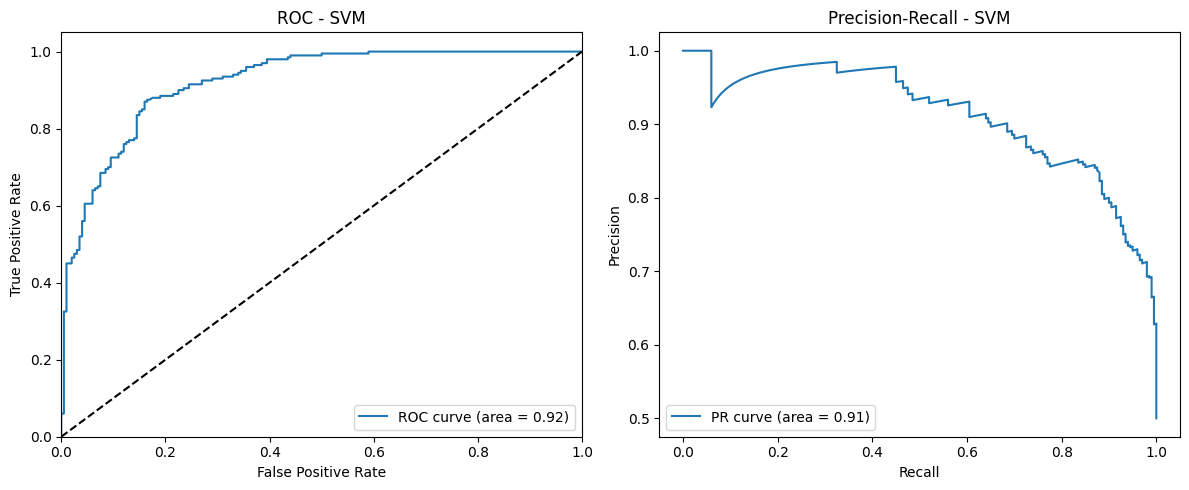

Random Forest Performance:
Accuracy: 0.8525
Recall: 0.8300
Precision: 0.8691
F1-Score: 0.8491
AUROC: 0.9251
AUPRC: 0.9228


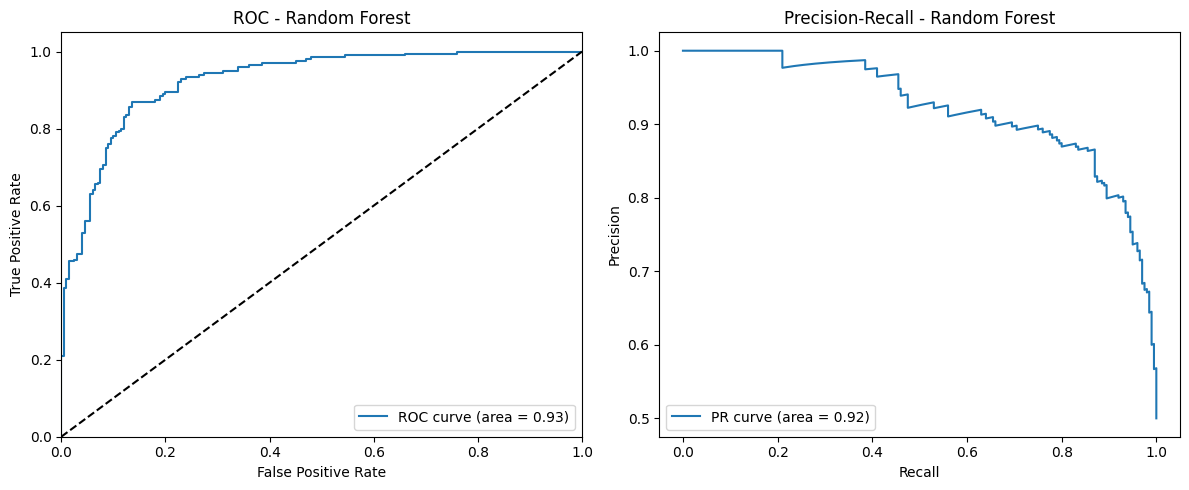

In [11]:
evaluate_model(best_svm, X_test_scaled, y_test, "SVM")

evaluate_model(best_rf, X_test, y_test, "Random Forest")